In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pathlib
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Process des données

In [ ]:
# Setup train and testing paths
data_path = pathlib.Path("/content/drive/My Drive/Colab Notebooks/DL/KaggleGlass/")
train_dir = data_path / "train"
test_dir = data_path / "test/small_test_set"

train_dir, test_dir

(PosixPath('/content/drive/My Drive/Colab Notebooks/DL/KaggleGlass/train'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/DL/KaggleGlass/test/small_test_set'))

In [ ]:
type(train_dir)

pathlib.PosixPath

#### Resize image

In [ ]:
data_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)), transforms.ToTensor()]  # Resize the images to 64x64*
)

# * this means we will need 64x64x3 input neurons

train_data = datasets.ImageFolder(root=train_dir,  # target folder of images
                                  transform=data_transform,  # transforms to perform on data (images)
                                  target_transform=None)  # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
    transform=data_transform)

In [ ]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 5013
    Root location: /content/drive/My Drive/Colab Notebooks/DL/KaggleGlass/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1500
    Root location: /content/drive/My Drive/Colab Notebooks/DL/KaggleGlass/test/small_test_set
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
test = np.array(train_data[0][0])
y = train_data

In [ ]:
class_names = train_data.classes
print(class_names)

['glasses', 'no_glasses']


Nous avons bien un tensor

torch.Size([64, 64, 3])


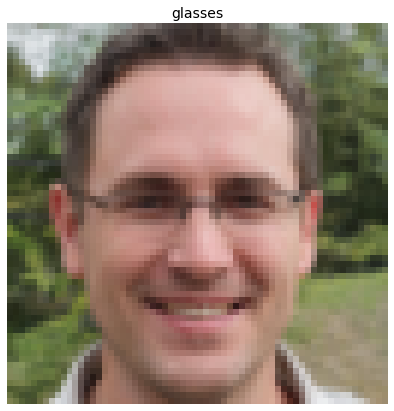

In [ ]:
test = train_data[3][0]
my_label = train_data[0][1]
test_reshaped = test.permute(1, 2, 0)
print(test_reshaped.shape)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(test_reshaped)
plt.axis("off")
plt.title(class_names[my_label], fontsize=14);

DataLoader

In [ ]:
print(type(train_data))

<class 'torchvision.datasets.folder.ImageFolder'>


In [ ]:
# Transform to normalized Tensors
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])


train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

train_dataset_array = next(iter(train_loader))[0].numpy()
# test_dataset_array = next(iter(test_loader))[0].numpy()

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size = 3
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=4,
    shuffle=False
) # don't usually need to shuffle testing data

In [ ]:
x_train = next(iter(train_dataloader))[0].numpy()
y_train = next(iter(train_dataloader))[1].numpy()

In [ ]:
y_train = y_train.T

x_train = x_train.T
x_train_reshape = x_train.reshape(-1, x_train.shape[-1]) / x_train.max()

m_train = 300
m_test = 80
x_train_reshape = x_train_reshape[:,:m_train]

print(x_train_reshape.shape)
print(y_train)


(12288, 3)
[0 0 0]


### Réseau de neurones

In [ ]:
class Net(nn.Module):
    def __init__(self, hidden_units=10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(64*64*3, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 2)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()

In [ ]:
def test_our_model():  # no arguments, literally all our variable our globals (not great but it's a notebook)
    # Put model in eval mode
    model.eval()  # to remove stuff like dropout that's only going to be in the training part

    # Setup test accuracy value
    test_acc = 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in test_dataloader:  # majuscule à X car c'est une "matrice", et y un entier
            # 1. Forward pass
            # print(X_test.shape)
            # print(X_test.view(-1, 64*64*3).shape)
            # break
            model_output = model(X_test.view(-1, 64*64*3))

            # 2. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax(dim=1)
            test_acc += (test_pred_label == y_test).sum()  # True == 1, False == 0

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = test_acc / (test_dataloader.batch_size*len(test_dataloader))
    print(test_acc.item())

test_our_model()

0.2593333423137665


In [ ]:
from tqdm import tqdm

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)

nbr_epochs: int = 20

def train(optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    for epoch in tqdm(range(nbr_epochs)):
        # Loop through data loader data batches
        for X, y in train_dataloader:
            # 1. Forward pass
            y_pred = model(X.view(-1, 64*64*3))

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (train_dataloader.batch_size * len(train_dataloader))
        train_acc = train_acc / (train_dataloader.batch_size * len(train_dataloader))
        print(
            f"epoch {epoch+1}/{nbr_epochs},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%"
        )

train(optimizer_sgd)

  5%|▌         | 1/20 [26:59<8:32:49, 1619.43s/it]

epoch 1/20, train_loss = 2.75e-03, train_acc = 99.94%


 10%|█         | 2/20 [28:56<3:40:44, 735.83s/it] 

epoch 2/20, train_loss = 3.49e-02, train_acc = 99.16%


 15%|█▌        | 3/20 [30:51<2:08:11, 452.42s/it]

epoch 3/20, train_loss = 4.16e-02, train_acc = 96.35%


 20%|██        | 4/20 [32:51<1:25:38, 321.16s/it]

epoch 4/20, train_loss = 4.14e-02, train_acc = 96.35%


 25%|██▌       | 5/20 [34:47<1:01:46, 247.13s/it]

epoch 5/20, train_loss = 4.14e-02, train_acc = 96.35%


 30%|███       | 6/20 [36:43<47:13, 202.37s/it]  

epoch 6/20, train_loss = 4.14e-02, train_acc = 96.35%


 35%|███▌      | 7/20 [38:40<37:50, 174.66s/it]

epoch 7/20, train_loss = 4.14e-02, train_acc = 96.35%


 40%|████      | 8/20 [40:37<31:15, 156.28s/it]

epoch 8/20, train_loss = 4.14e-02, train_acc = 96.35%


 45%|████▌     | 9/20 [42:35<26:25, 144.17s/it]

epoch 9/20, train_loss = 4.14e-02, train_acc = 96.35%


 50%|█████     | 10/20 [44:31<22:34, 135.41s/it]

epoch 10/20, train_loss = 4.14e-02, train_acc = 96.35%


 55%|█████▌    | 11/20 [46:29<19:30, 130.07s/it]

epoch 11/20, train_loss = 4.14e-02, train_acc = 96.35%


 60%|██████    | 12/20 [48:24<16:45, 125.72s/it]

epoch 12/20, train_loss = 4.14e-02, train_acc = 96.35%


 65%|██████▌   | 13/20 [50:20<14:17, 122.56s/it]

epoch 13/20, train_loss = 4.14e-02, train_acc = 96.35%


 70%|███████   | 14/20 [52:17<12:06, 121.04s/it]

epoch 14/20, train_loss = 4.14e-02, train_acc = 96.35%


 75%|███████▌  | 15/20 [54:13<09:56, 119.37s/it]

epoch 15/20, train_loss = 4.14e-02, train_acc = 96.35%


 80%|████████  | 16/20 [56:10<07:54, 118.65s/it]

epoch 16/20, train_loss = 4.14e-02, train_acc = 96.35%


 85%|████████▌ | 17/20 [58:05<05:52, 117.56s/it]

epoch 17/20, train_loss = 4.14e-02, train_acc = 96.35%


 90%|█████████ | 18/20 [1:00:01<03:54, 117.08s/it]

epoch 18/20, train_loss = 4.14e-02, train_acc = 96.35%


 95%|█████████▌| 19/20 [1:01:56<01:56, 116.66s/it]

epoch 19/20, train_loss = 4.14e-02, train_acc = 96.35%


100%|██████████| 20/20 [1:03:52<00:00, 191.61s/it]

epoch 20/20, train_loss = 4.14e-02, train_acc = 96.35%


### Lecture du fichier small test

In [ ]:
my_iterable = iter(test_dataloader)

In [ ]:
X_test_one_batch, y_test_one_batch = next(my_iterable)
X_test_one, y_test_one = X_test_one_batch[0], y_test_one_batch[0]
print(X_test_one_batch.shape)

torch.Size([4, 3, 64, 64])


tensor([[0.2887, 0.0810]], grad_fn=<AddmmBackward0>)
tensor(0)
Predicted class: glasses
Actual class: glasses


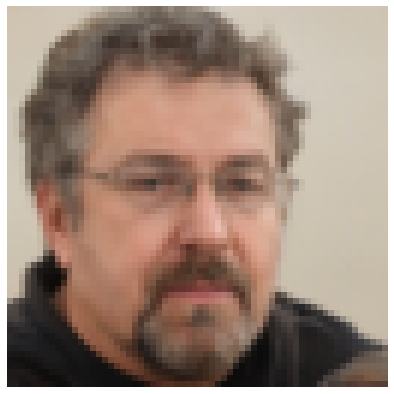

In [ ]:
# 0. Eval mode
model.eval()

# 1. Forward pass
model_output = model(X_test_one.view(-1, 64*64*3))

print(model_output)

# 2. Calculate predicted label
test_pred_label = model_output.argmax()

print(test_pred_label)

# 3. Display
print(f"Predicted class: {class_names[test_pred_label]}")
print(f"Actual class: {class_names[y_test_one]}")
plt.figure(figsize=(10, 7))
plt.imshow(X_test_one.permute(1, 2, 0))
_ = plt.axis("off")

### Réseau de neurones

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
def logloss(A,y):
  epsilon = 1e-15
  return 1 / len(y) * np.sum(-y*np.log(A+epsilon)- (1-y) * np.log(1-A + epsilon))

In [ ]:
def initialisation_reseau(dimensions):

  param ={}
  c = len(dimensions)

  for c in range(1,c):
    param['W'+str(c)] = np.random.randn(dimensions[c],dimensions[c-1])
    param['b'+str(c)] = np.random.randn(dimensions[c],1)

  return param

In [ ]:
def forward_propagation(X, param):

  activations = {'A0':X}
  C = len(param) //2

  for c in range(1,C+1):
    z = param['W' + str(c)].dot(activations['A' + str(c-1)]) + param['b' + str(c)]
    activations['A' + str(c)] = 1 / (1+np.exp(-z))
  return activations

In [ ]:
def back_propagation(y, activations, param):

  m = y.shape[1]
  C = len(param) // 2

  dZ = activations['A' + str(C)] - y
  gradients = {}

  for c in reversed(range(1,C+1)):
    gradients['dW'+str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c-1)].T)
    gradients['db'+str(c)] = 1 / m * np.sum(dZ, axis = 1, keepdims = True)
    if c>1:
      dZ = np.dot(param['W' +str(c)].T, dZ) * activations['A'+str(c-1)] * (1-activations['A' + str(c-1)])
  return gradients

In [ ]:
def update_reseau(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [ ]:
def predict_reseau(X, parametres):
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  Af = activations['A' + str(C)]
  return Af >= 0.5

In [ ]:
def neural_net(X,y, hidden_layers, lr, n_iter):

  #initialisation des param W et b
  dimensions = list(hidden_layers)
  dimensions.insert(0,X.shape[0])
  dimensions.append(y.shape[0])
  param = initialisation_reseau(dimensions)

  train_Loss = []
  train_acc = []
  label = []

  for i in tqdm(range(n_iter)):

    activations = forward_propagation(X, param)
    gradients = back_propagation(y, activations, param)
    param = update_reseau(gradients, param, lr)

    if i%10 == 0:

      C = len(param) // 2
      train_Loss.append(logloss(activations['A' + str(C)], y))
      y_pred = predict_reseau(X,param)
      label.append(y_pred)
      current_accuracy = accuracy_score(y.flatten(), y_pred.flatten())
      train_acc.append(current_accuracy)


  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  plt.plot(train_Loss, label = 'train loss')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(train_acc, label = 'train acc')
  plt.show()

  return param, label

In [ ]:
X_train = next(iter(train_dataloader))[0].numpy()
y_train = next(iter(train_dataloader))[1].numpy()
# test_dataset_array = next(iter(test_loader))[0].numpy()

#print(train_dataloader)

In [ ]:
print(X_train.T.shape)

(64, 64, 3, 4)


In [ ]:
hidden_layers = (16,16,16)
param, label = neural_net(X_train, y_train, hidden_layers, n_iter = 100, lr = 0.1)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: ignored